In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import numpy as np
import os
import torch
import torch.nn as nn
import shutil
import matplotlib.pyplot as plt
import h5py
import pandas as pd

In [ ]:
from src.utils.logger import Logging
from src.nn.DVPDESolver import DVPDESolver
from src.nn.CVPDESolver import CVPDESolver
from src.nn.ClassicalSolver import ClassicalSolver
from src.utils.error_metrics import lp_error


# from src.utils.cavity_plot_contour import draw_contourf_regular_2D
# from src.utils.color import model_color
# from src.utils.plot_loss import plot_loss_history

In [ ]:
log_path = "./testing_checkpoints"
logger = Logging(log_path)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Generate Testing Dataset


In [5]:
skip = 4
tstep = 101
xstep = 100
ystep = 100

TEST_DATA_PKL = "./data/cavity.mat"  # Assuming this is the correct path
data = h5py.File(TEST_DATA_PKL, "r")  # load dataset from matlab

domain = pd.DataFrame(data["cavity_internal"]).T.to_numpy()

#  t = tf.reshape(tstep,N_data)[:,0].T
time_ = (
    domain[:, 0:1].reshape(tstep, xstep, ystep)[:, ::skip, ::skip].reshape(-1, 1)
)  # (101, 10, 10)
xfa = domain[:, 1:2].reshape(tstep, xstep, ystep)[:, ::skip, ::skip].reshape(-1, 1)
yfa = domain[:, 2:3].reshape(tstep, xstep, ystep)[:, ::skip, ::skip].reshape(-1, 1)
ufa = domain[:, 3:4].reshape(tstep, xstep, ystep)[:, ::skip, ::skip].reshape(-1, 1)
vfa = domain[:, 4:5].reshape(tstep, xstep, ystep)[:, ::skip, ::skip].reshape(-1, 1)
pfa = domain[:, 5:6].reshape(tstep, xstep, ystep)[:, ::skip, ::skip].reshape(-1, 1)

In [ ]:
new_shape = domain[:, 0:1].reshape(tstep, xstep, ystep)[:, ::skip, ::skip].shape

# Load trained model


In [ ]:
model_dir = "models/2025-02-06_19-28-34-814985"  # sim_circ_13_half

In [ ]:
model_path = os.path.join(model_dir, "model.pth")
state = DVPDESolver.load_state(model_path)
solver = state["args"]["solver"]


if solver == "CV":
    state = CVPDESolver.load_state(model_path)
    model = CVPDESolver(state["args"], logger, data, DEVICE)

    model.preprocessor.load_state_dict(state["preprocessor"])
    model.quantum_layer.load_state_dict(state["quantum_layer"])
    model.postprocessor.load_state_dict(state["postprocessor"])

elif solver == "Classical":
    state = ClassicalSolver.load_state(model_path)

    if "hidden_network" in state:
        from src.nn.ClassicalSolver2 import ClassicalSolver2

        state = ClassicalSolver2.load_state(model_path)
        model = ClassicalSolver2(state["args"], logger, data, DEVICE)
        model.preprocessor.load_state_dict(state["preprocessor"])
        model.hidden.load_state_dict(state["hidden_network"])
        model.postprocessor.load_state_dict(state["postprocessor"])

    else:
        from src.nn.ClassicalSolver import ClassicalSolver

        model = ClassicalSolver(state["args"], logger, data, DEVICE)
        model.preprocessor.load_state_dict(state["preprocessor"])
        model.postprocessor.load_state_dict(state["postprocessor"])

elif solver == "DV":
    state = DVPDESolver.load_state(model_path)
    model = DVPDESolver(state["args"], logger, data, DEVICE)
    model.preprocessor.load_state_dict(state["preprocessor"])
    model.postprocessor.load_state_dict(state["postprocessor"])
    model.quantum_layer.load_state_dict(state["quantum_layer"])

else:
    raise ValueError(f"Unknown solver: {solver}")

model.logger = logger
model.logger.print(f"The settings used: {model.args}")
for key, value in model.args.items():
    model.logger.print(f"{key} : {value}")

model.logger.print(f"Totoal number of iterations : , {len(state['loss_history'])}")
model.logger.print(f"The final loss : , {state['loss_history'][-1]}")

model.loss_history = state["loss_history"]
model.model_path = logger.get_output_dir()


# Print total number of parameters
total_params = sum(p.numel() for p in model.parameters())
model.logger.print(f"Total number of parameters: {total_params}")
shutil.copytree(
    model_dir,
    os.path.join(logger.get_output_dir(), model_dir.split("/")[-1]),
    dirs_exist_ok=True,
)

Model state loaded from models/2025-02-06_19-28-34-814985/model.pth
Model state loaded from models/2025-02-06_19-28-34-814985/model.pth


INFO:src.utils.logger:The settings used: {'batch_size': 64, 'epochs': 20000, 'lr': 0.0001, 'seed': 1, 'print_every': 50, 'log_path': './checkpoints/cavity', 'input_dim': 3, 'output_dim': 3, 'num_qubits': 5, 'hidden_dim': 50, 'num_quantum_layers': 1, 'classic_network': [3, 50, 3], 'q_ansatz': 'sim_circ_19', 'mode': 'hybrid', 'activation': 'tanh', 'shots': None, 'problem': 'cavity', 'solver': 'DV', 'method': 'None', 'device': 'cpu', 'cutoff_dim': 3, 'class': 'DVQuantumLayer', 'encoding': 'angle'}
INFO:src.utils.logger:batch_size : 64
INFO:src.utils.logger:epochs : 20000
INFO:src.utils.logger:lr : 0.0001
INFO:src.utils.logger:seed : 1
INFO:src.utils.logger:print_every : 50
INFO:src.utils.logger:log_path : ./checkpoints/cavity
INFO:src.utils.logger:input_dim : 3
INFO:src.utils.logger:output_dim : 3
INFO:src.utils.logger:num_qubits : 5
INFO:src.utils.logger:hidden_dim : 50
INFO:src.utils.logger:num_quantum_layers : 1
INFO:src.utils.logger:classic_network : [3, 50, 3]
INFO:src.utils.logger:q

'./testing_checkpoints/2025-04-26_12-33-21-833224/2025-02-06_19-28-34-814985'

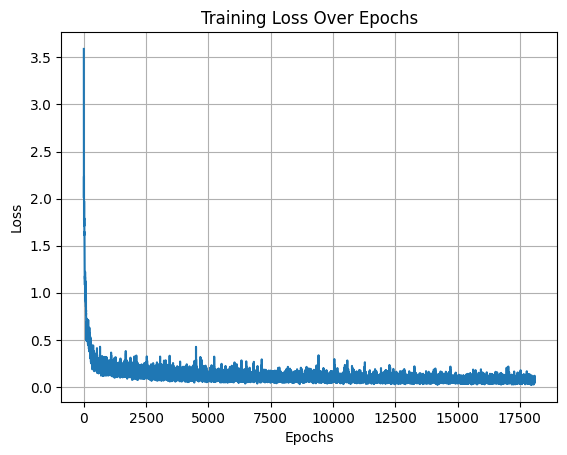

In [ ]:
plt.plot(range(len(model.loss_history)), model.loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid()

file_path = os.path.join(model.log_path, "loss_history.pdf")
plt.savefig(file_path, bbox_inches="tight")
plt.show()

plt.close(
    "all",
)

## Prediction Results


In [ ]:
test_torch_data = torch.tensor(
    np.concatenate([time_, xfa, yfa], axis=1), dtype=torch.float32
).to(model.device)
with torch.no_grad():
    predictions = model.forward(test_torch_data)
if predictions.is_cuda:
    predictions = predictions.cpu()
u_pred = predictions[:, 0:1].numpy()
v_pred = predictions[:, 1:2].numpy()
p_pred = predictions[:, 2:3].numpy()

INFO:src.utils.logger:The circuit used in the study:


The circuit is saved in ./testing_checkpoints/2025-04-26_11-48-52-615955


In [16]:
text = "RelL2_"
# logger.print("\n Relative L2 ERROR:")
u_error2 = lp_error(u_pred, ufa, (text + "U%"), logger, 2)
v_error2 = lp_error(v_pred, vfa, (text + "V%"), logger, 2)
p_error2 = lp_error(p_pred, pfa, (text + "P%"), logger, 2)

logger.print("******************************\n")

logger.print("file directory:", logger.get_output_dir())

INFO:src.utils.logger:RelL2_U%  : 1.949e+01 
INFO:src.utils.logger:RelL2_V%  : 3.676e+01 
INFO:src.utils.logger:RelL2_P%  : 3.305e+01 
INFO:src.utils.logger:******************************

INFO:src.utils.logger:file directory:
INFO:src.utils.logger:./testing_checkpoints/2025-04-26_11-48-52-615955


In [ ]:
tstep = new_shape[0]
xstep = new_shape[1]
ystep = new_shape[2]

txy = [xfa, yfa, time_]
steps = [tstep, xstep, ystep]

#  t = tf.reshape(tstep,N_data)[:,0].T
tf = time_.reshape(tstep, xstep, ystep)
xf = xfa.reshape(tstep, xstep, ystep)
yf = yfa.reshape(tstep, xstep, ystep)


exact_u = ufa.reshape(tstep, xstep, ystep)  # .reshape(100,100)[0,:]
exact_v = vfa.reshape(tstep, xstep, ystep)  # .reshape(100,100)[0,:]
exact_p = pfa.reshape(tstep, xstep, ystep)  # [1,:].reshape(100,100)[0,:]

u_pred_tanh = u_pred.reshape(tstep, xstep, ystep)  # .reshape(100,100)[0,:]
v_pred_tanh = v_pred.reshape(tstep, xstep, ystep)  # .reshape(100,100)[0,:]
p_pred_tanh = p_pred.reshape(tstep, xstep, ystep)  # [1,:].reshape(100,100)[0,:]

### OR Simply call the python script

```bash
python -m src.contour_plots.cavity_hybrid_plotting
```


INFO:src.utils.logger:checkpoint path: self.log_path='testing_checkpoints/cavity/2025-04-26_12-48-29-120304'
INFO:src.utils.logger:number of parameters: 8003
INFO:src.utils.logger:Final loss: 0.08730538189411163
INFO:src.utils.logger:Total number of iterations: 20001


Model state loaded from ./models/2025-02-25_17-21-36-221407/model.pth
Model state loaded from ./models/2025-02-25_17-21-36-221407/model.pth


INFO:src.utils.logger:RelL2_U%  : 2.103e+01 
INFO:src.utils.logger:RelL2_V%  : 3.027e+01 
INFO:src.utils.logger:RelL2_P%  : 2.317e+01 
INFO:src.utils.logger:classical Errors - U: 2.10e+01, V: 3.03e+01, P: 2.32e+01
INFO:src.utils.logger:DV Model loaded successfully
INFO:src.utils.logger:number of parameters: 923
INFO:src.utils.logger:Final loss: 0.0921594500541687
INFO:src.utils.logger:Total number of iterations: 18100
INFO:src.utils.logger:The circuit used in the study:


Model state loaded from ./models/2025-02-06_19-28-34-814985/model.pth
The circuit is saved in testing_checkpoints/cavity/2025-04-26_12-48-29-120304


INFO:src.utils.logger:RelL2_U%  : 2.247e+01 
INFO:src.utils.logger:RelL2_V%  : 3.446e+01 
INFO:src.utils.logger:RelL2_P%  : 3.566e+01 
INFO:src.utils.logger:angle_cascade Errors - U: 2.25e+01, V: 3.45e+01, P: 3.57e+01


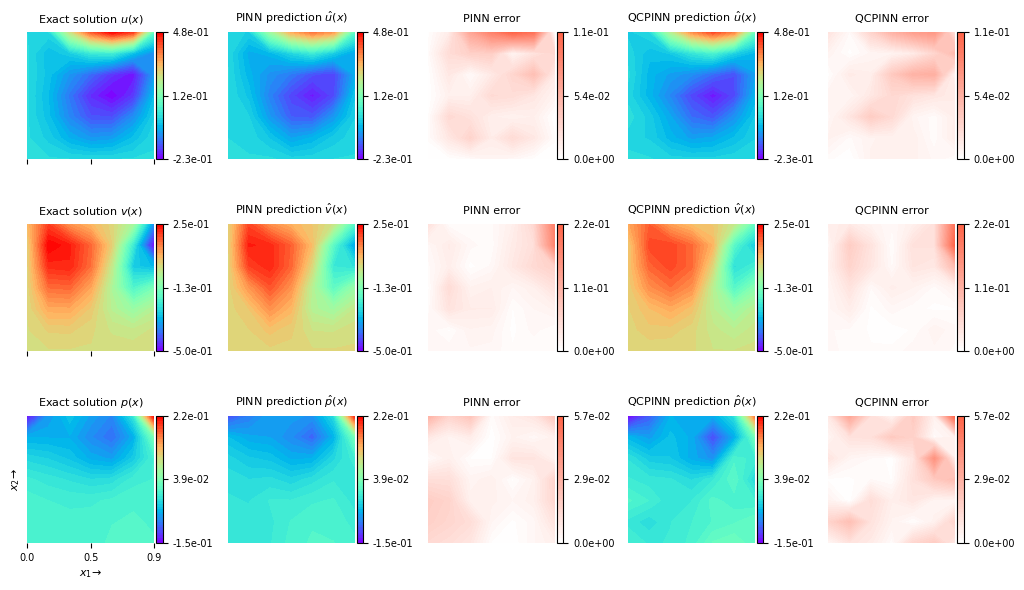

In [19]:
run -m src.contour_plots.cavity_hybrid_plotting